## Analysis script

In [2]:
%%writefile analyse.py
# felix zimmermann, github.com/fzimmermann89 for beamtime kuschel2023

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from data_helper import *
import accumulators
from pathlib import Path
from filters import *
from calculators import *

import exp_config

def analyserun(runNR, max_shots=np.inf, step_shots=1):
    run=Run(exp_config.detector_keys,exp_config.database_keys, run=int(runNR))
    
    #accumulators
    spectrum_mean=accumulators.Mean()
    forward_mean=accumulators.Mean()
    forward_hist_mean=accumulators.Mean()
    forward_total = []
    side_mean=accumulators.Mean()
    side_max=accumulators.Maximum()
    side_hist_mean=accumulators.Mean()
    side_bright_pershot = []
    side_total = []
    spectrum=[]

    #calculators
    side_hist = Histogrammer(bins=200, range=(0,50000))
    forward_hist = Histogrammer(bins=200, range=(0,50000)) 
    side_bright_counter = RangeCounter(low=40) 
    top = topk(k=5) # 5 brightest images
    cut_noise=NoiseCutter(1000) #sets values below 1000ev to zero

    #shot filtering    
    good_shots = filter_shutter(run)(filter_xstep(run)())
    good_shots = good_shots[range(0,min(max_shots, len(good_shots)), step_shots)]

    print("good_shots:",good_shots)
    

    for i in tqdm(good_shots):
        shot = run[i]
        # do something with the data.

        #spectrometer
        current_spectrum = np.mean(shot.spectrometer, axis=1)
        spectrum_mean.accumulate(current_spectrum)
        spectrum.append(current_spectrum)

        #image detectors
        side_image = cut_noise(shot.side_ccd)
        side_image_sum = np.sum(side_image)
        forward_image = cut_noise(shot.forward_ccd)
        forward_image_sum = np.sum(forward_image)
        
        side_mean.accumulate(side_image)
        forward_mean.accumulate(forward_image)
        side_max.accumulate(shot.side_ccd)

        side_bright_pershot.append(side_bright_counter(shot.side_ccd))
        side_total.append(side_image_sum)
        forward_total.append(forward_image_sum)
        
        #brightest images
        dat = (forward_image_sum, side_image_sum, forward_image, side_image, i)
        brightness = forward_image_sum
        top.add(brightness,dat)
       
        #image hists
        side_hist_mean.accumulate(side_hist(shot.side_ccd))
        forward_hist_mean.accumulate(forward_hist(shot.forward_ccd))
    
    #get values of brightest images
    forward_top_image_sum,side_top_image_sum,forward_top_images,side_top_images,i_top_images=zip(*top.get())
    
    
    return to_dict(run, shots_taken=good_shots, side_mean=side_mean,forward_mean=forward_mean,side_hist_mean=side_hist_mean,forward_hist_mean=forward_hist_mean,forward_hist_centers=forward_hist.centers(),side_hist_centers=side_hist.centers(),side_bright_pershot=side_bright_pershot,side_max=side_max,side_total=side_total,forward_total=forward_total, runNR=runNR,spectrum_mean=spectrum_mean,spectrum=spectrum,spectrum_axis=exp_config.spectrometer_axis_gold, 
              forward_top_images=forward_top_images,    forward_top_image_sum=forward_top_image_sum,    side_top_image_sum=side_top_image_sum,    side_top_image=side_top_images,    i_top_images=i_top_images,)

if __name__ == "__main__":
    import argparse
    parser=argparse.ArgumentParser()
    parser.add_argument("run")
    args=parser.parse_args()

    outpath=f"/work/kuschel/2023TRsHardXray/scratch/ulmer/data/run_data/data1_run{args.run}.npz"
    print("will save to",outpath)     
    data = analyserun(runNR=args.run)
    print("done", outpath)
    np.savez_compressed(outpath,**data)


Overwriting analyse.py


In [3]:
%writefile job.pbs

#PBS -S /bin/bash
#PBS -q serial
#PBS -l nodes=1
#PBS -l mem=8gb
#PBS -l ncpus=4
#PBS -l walltime=1:00:00

## run with qsub job.pbs -J STARTRUN-ENDRUN:STEPRUN 
##start and end are inclusive / inclusive


source /home/blstaff/SACLAtool_py3.7
module load SACLA_tool/1.0.0
module load python/SACLA_python-3.7/offline

# adjust path to script here
python /work/kuschel/2023TRsHardXray/scratch/ulmer/analyse/analyse.py $PBS_ARRAY_INDEX


SyntaxError: invalid syntax (3312256850.py, line 14)

# Start Jobs

In [100]:
!qstat

Job id            Name             User              Time Use S Queue
----------------  ---------------- ----------------  -------- - -----
4933611.fep01     STDIN            nakasako          03:57:58 R long            
4934217.fep01     STDIN            inoue             00:31:01 R serial          
4934255.fep01     Jupyter          inoue             00:03:02 R serial          
4934538.fep01     STDIN            nojiri            14:55:25 R serial          
4934738.fep01     STDIN            muthreich         00:00:01 R serial          
4934880.fep01     STDIN            yanwen            01:47:09 R serial          
4934891.fep01     STDIN            ulmer             00:00:26 R serial          
4934897.fep01     STDIN            ulmer             00:06:02 R serial          


In [ ]:
start_run = 1313933


In [ ]:
from data_helper import getNewestRun

end_run = getNewestRun()

current_run = start_run
while current_run < end_run:
    srun = int(current_run)
    erun = int(min(current_run+49, end_run))
    print(f'starting job for runs: {srun} to {erun}')
    !qsub -o logs/ -e logs/ -J $srun-$erun job.pbs
    current_run += 50
start_run = end_run

In [5]:
!qstat

Job id            Name             User              Time Use S Queue
----------------  ---------------- ----------------  -------- - -----
4933611.fep01     STDIN            nakasako          04:49:23 R long            
4934538.fep01     STDIN            nojiri            23:10:37 R serial          
4934738.fep01     STDIN            muthreich         00:00:01 R serial          
4934880.fep01     STDIN            yanwen            03:04:35 R serial          
4934891.fep01     STDIN            ulmer             00:00:26 R serial          
4934897.fep01     STDIN            ulmer             01:21:49 R serial          
4935240.fep01     512_v11-1        mamoru.suzuki     02:47:08 R serial          
4935244[].fep01   job.pbs          ulmer                    0 B serial          
4935245[].fep01   job.pbs          ulmer                    0 B serial          
4935246[].fep01   job.pbs          ulmer                    0 Q serial          
4935247.fep01     511_v11-1        mamoru.suzuki  

In [4]:
# for i in range(4935001,4935051):
#     !qdel $i[].fep01

# Auswertung

In [103]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from data_helper import *
import accumulators
from pathlib import Path
from filters import *
from calculators import *
import datetime
from radial_profile import radial_profile
import exp_config

## Plot for each run

In [ ]:
START = 1314826


In [133]:


END=getNewestRun()

path=Path("/work/kuschel/2023TRsHardXray/scratch/ulmer/data/run_data/")
for data_dict in read_data_generator(path, minrun=START, maxrun=END):
    # i0=rundata["diode"]
    # current_fluorescence_normalized=np.nanmean(rundata["side_total"]/i0)
    # fluorescence_normalized.append(current_fluorescence_normalized)
    # energy.append(rundata["spectrum_axis"][np.argmax(rundata["spectrum_mean"])])
    # attenuation= 1
    print(data_dict["runNR"])
    fig, ax = plt.subplots(2,2, figsize=(15,10))
    n=len(data_dict["tag"])
    runNR=data_dict["runNR"]
    
    #mean images
    im = ax[0,0].imshow(data_dict['forward_mean'])
    ax[0,0].set_title("mean image forward det")
    plt.colorbar(im, ax=ax[0,0])
    # ax[0,0].show()

    im2 = ax[0,1].imshow(data_dict['side_mean'])
    ax[0,1].set_title("mean image side det")
    plt.colorbar(im2, ax=ax[0,1])
    # ax[0,1].show()


    #Spectrometer Plot
    ax[1,0].plot(data_dict["spectrum_axis"], data_dict['spectrum_mean'], label=f"Mean over {n} shots")
    ax[1,0].set_xlabel("energy fel / ev")
    ax[1,0].set_ylabel("a.u")
    ax[1,0].set_title(f"Spectrometer run {runNR}")
    ax[1,0].legend()
    # ax[1,0].show()

    
    #Fluorescence Spectrum
    ax[1,1].plot(data_dict['side_hist_centers'], data_dict['side_hist_mean'], label=f"side,over {n} shots")
    ax[1,1].set_xlabel("~ev")
    ax[1,1].set_ylabel("a.u.")
    ax[1,1].set_title(f"Histogram run {runNR}")
    ax[1,1].set_yscale("log")
    ax[1,1].plot(data_dict['forward_hist_centers'], data_dict['forward_hist_mean'], label=f"forward, Mean over {n} shots")
    ax[1,1].legend()
    for i in range(1,4):
        plt.axvline(i*6400,color="gray")
    for i in range(1,4):
        plt.axvline(i*9650,color="yellow")
    plt.axvline(9650+6400,linestyle="-",color="yellow")
    plt.axvline(9650+6400,linestyle="--",color="gray", )
    plt.axvline(2*9650+6400,linestyle="-",color="yellow")
    plt.axvline(2*9650+6400,linestyle="--",color="gray", )
    plt.axvline(9650+2*6400,linestyle="-",color="yellow")
    plt.axvline(9650+2*6400,linestyle="--",color="gray", )
    fig.savefig(f"/work/kuschel/2023TRsHardXray/scratch/ulmer/data/plots/plt_{runNR}.png")
    plt.close()
    #plt.show()
    
START=END

1314976
1314977
1314978
1314979
1314980
1314981
1314982
1314983
1314984
1314985
1314986
1314987
1314988
1314989
1314990
1314991
1314992
1314993
1314994
1314995
1315025
1315026
1315027
1315028
1315029
1315030
1315031
1315032
1315033
1315035
1315036
1315037
1315038
1315313
1315314
1315315
1315316
1315317
1315318
1315319
1315320
1315321
1315322
1315323
1315324
1315325
1315326
1315327
1315328
1315329
1315330
1315331
1315332
1315333
1315334
1315335
1315336
1315337
1315338
1315339
1315340
1315341
1315342
1315343
1315344
1315345
1315346
1315347
1315348
1315349
1315350
1315351
1315352
1315353
1315354
1315355
1315356
1315357
1315358
1315359
1315360
1315361
1315362
1315363
1315364
1315365
1315366


# find focus

In [126]:
START=1315353
END=START+13

### create files

In [118]:
from data_helper import getNewestRun

start_run = START
end_run = END
current_run = start_run
while current_run < end_run:
    srun = int(current_run)
    erun = int(min(current_run+49, end_run))
    print(f'starting job for runs: {srun} to {erun}')
    !qsub -o logs/ -e logs/ -J $srun-$erun job.pbs
    current_run += 50


starting job for runs: 1314976 to 1314988
4934982[].fep01


### Y scan plot & fit

1it [00:00,  6.87it/s]

1315353
1315354
1315355


5it [00:00, 13.39it/s]

1315356
1315357
1315358
1315359


9it [00:00, 15.33it/s]

1315360
1315361
1315362
1315363


14it [00:00, 14.80it/s]

1315364
1315365
1315366


Text(0.5, 1.0, '-4541')

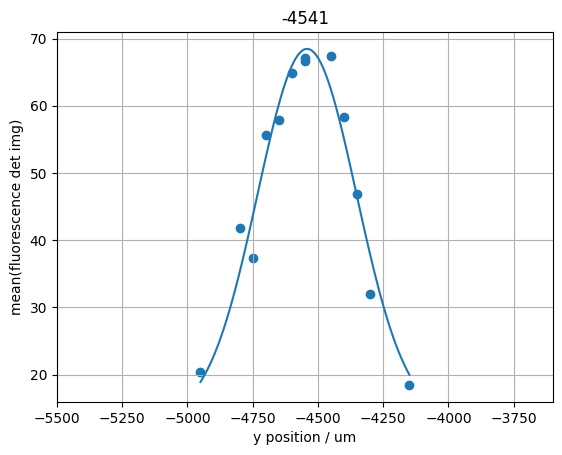

In [131]:

x=[]
y=[]

path=Path("/work/kuschel/2023TRsHardXray/scratch/ulmer/data/run_data/")
for data_dict in tqdm(read_data_generator(path, minrun=START, maxrun=END)):
    # i0=rundata["diode"]
    # current_fluorescence_normalized=np.nanmean(rundata["side_total"]/i0)
    # fluorescence_normalized.append(current_fluorescence_normalized)
    # energy.append(rundata["spectrum_axis"][np.argmax(rundata["spectrum_mean"])])
    # attenuation= 1

    print(data_dict["runNR"])
    mask = np.ones_like(data_dict['side_mean'])
    mask[:270,:] = np.nan
    mask[920:,:] = np.nan
    mask[:,1070:] = np.nan
    mask[:,:580] = np.nan
    y.append(np.nanmean(data_dict['side_mean']*mask))
    x.append(np.median(data_dict['sampleY']))
del x[8]
del y[8]
x=np.array(x)*1e6
y=np.array(y)


import scipy.optimize
def gaussian(x, a, cen, sigma, bg):
    return np.abs(a*np.exp(-(x-cen)**2/2/sigma**2))+bg
p0=[np.max(y), np.mean(x),100, np.min(y)]
py, _ = scipy.optimize.curve_fit(gaussian, np.array(x), y, p0=p0)
plt.scatter(np.array(x),y)
xf=np.linspace(np.min(x),np.max(x),100)

plt.plot(xf,gaussian(xf, *py))
plt.xlim(-8000, -1000)
plt.xlabel('y position / um')
plt.ylabel('mean(fluorescence det img)')
plt.xlim(-5500,-3600)
# plt.xlim(-4900,-4300)
plt.grid(1)
plt.title(int(py[1]))

In [132]:
py

array([   54.94871198, -4541.79977585,   189.48818084,    13.51715463])

# Attenuator scan plot

1it [00:00,  6.88it/s]

1314988
1314989
1314990


8it [00:00, 16.60it/s]

1314991
1314992
1314993
1314994
1314995


Text(0, 0.5, 'mean(fluorescence det img)')

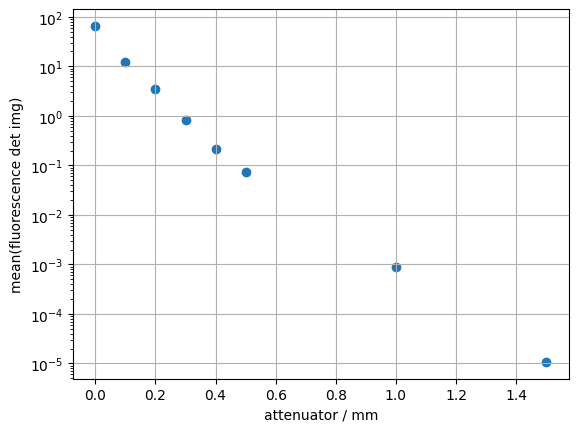

In [ ]:
# START=1314988
# END=1314995

START=1314919
END=1314925

x=[]
y=[]

path=Path("/work/kuschel/2023TRsHardXray/scratch/ulmer/data/run_data/")
for data_dict in tqdm(read_data_generator(path,minrun=START, maxrun=END)):
    # i0=rundata["diode"]
    # current_fluorescence_normalized=np.nanmean(rundata["side_total"]/i0)
    # fluorescence_normalized.append(current_fluorescence_normalized)
    # energy.append(rundata["spectrum_axis"][np.argmax(rundata["spectrum_mean"])])
    # attenuation= 1

    print(data_dict["runNR"])
    mask = np.ones_like(data_dict['side_mean'])
    mask[:270,:] = np.nan
    mask[920:,:] = np.nan
    mask[:,1070:] = np.nan
    mask[:,:580] = np.nan
    y.append(np.nanmean(data_dict['side_mean']*mask))
    x.append(np.median(data_dict['attenuator_eh_5_Si_mm']*1e3))
x=np.array(x)

#y=np.array(y)/96
#y=y*(0.435**(np.array(x)/0.0001))np.min(y)
plt.scatter(np.array(x),y)
plt.yscale('log')
plt.grid()
plt.xlabel('attenuator / mm')
plt.ylabel('mean(fluorescence det img)')

# Plot brightest Shots

# Darks

In [245]:
from pathlib import Path


def create_darks(run, path):
    path=Path(path)
    #accumulators
    forward_mean=accumulators.Mean()
    side_mean=accumulators.Mean()
    (path/"forward").mkdir(parents=True,exist_ok=True)
    (path/"side").mkdir(parents=True,exist_ok=True)
    for shot in tqdm(Run(exp_config.detector_keys,exp_config.database_keys, run=run, detector_dark_files=None)):
        # do something with the data.


        #image detectors
        side_mean.accumulate(shot.side_ccd)
        forward_mean.accumulate(shot.forward_ccd)
    time = int(dbpy.read_starttime(3,run))
    np.save(path/f"side/{run}_{time}.npy",side_mean.value)
    np.save(path/f"forward/{run}_{time}.npy",forward_mean.value)

for dark_run in [1315673,]:
    create_darks(run=dark_run, path="../data/darks/")



100%|█████████████████████████████████████████| 100/100 [00:09<00:00, 10.29it/s]
